In [1]:
# Import libraries and data
import os
import numpy as np
import pickle

from src.utils.linear_regressor import perform_linear_regression
from config.settings import saved_models_path
from src.utils.column_import import columns_dif

s_x , s_y , v_x , v_y , a_x , a_y, a_x_a, a_y_a, a_x_b, a_y_b = columns_dif






/home/ali/tum/motion_planning/social_ai_practical_course/data/processed/inD/x_y_recording_00_range_384.csv
/home/ali/tum/motion_planning/social_ai_practical_course/data/processed/scenario_samples/lane_merging/dif_set/test_set_00.csv


# Relative Model (2 cars)


Acceleration model with 4 parameters
\begin{align}
a(k-1) &= - \overline c_1 a(k)  + \overline c_2 \bigl( v(k+1) - v(k) \bigr) \\
a(k-1) &= - \overline c_3 a(k)  + \overline c_4 \bigl( s(k+1) - s(k) - dt \  v(k)\bigr)
\end{align}

Model in matrix notation
\begin{align}
    \begin{bmatrix}
        a(k-1) \\ a(k-1)       
    \end{bmatrix}
    =
    \begin{bmatrix}
         -a(k)  & v(k+1) - v(k)  & 0 & 0 \\
         0 & 0 & -a(k) &    s(k+1) - s(k) - dt \  v(k)
        \end{bmatrix}
        \begin{bmatrix}
        \overline c_1 \\
        \overline c_2 \\
        \overline c_3 \\
        \overline c_4 \\
    \end{bmatrix}
\end{align}

Add x and y components

\begin{align}
    \begin{bmatrix}
        a_x(k-1) \\ 
        a_x(k-1) \\ 
        a_y(k-1) \\ 
        a_y(k-1)       
    \end{bmatrix}
    =
    \begin{bmatrix}
        -a_x(k)  & v_x(k+1) - v_x(k)  & 0 & 0                   \\ 
        0 & 0 & -a_x(k) &    s_x(k+1) - s_x(k) - dt \  v_x(k)   \\ 
        -a_y(k)  & v_y(k+1) - v_y(k)  & 0 & 0                   \\
        0 & 0 & -a_y(k) &    s_y(k+1) - s_y(k) - dt \  v_y(k)
    \end{bmatrix}
    \begin{bmatrix}
        \overline c_1 \\
        \overline c_2 \\
        \overline c_3 \\
        \overline c_4 \\
   \end{bmatrix}
\end{align}

For easier implementation split into two models

First model
\begin{align}
    \begin{bmatrix}
        a_x(k-1) \\ 
        a_y(k-1) \\ 
    \end{bmatrix}
    =
    \begin{bmatrix}
        -a_x(k)  & v_x(k+1) - v_x(k)   \\ 
        -a_y(k)  & v_y(k+1) - v_y(k)   \\
    \end{bmatrix}
    \begin{bmatrix}
        \overline c_1 \\
        \overline c_3 \\
   \end{bmatrix}
\end{align}



Second model
\begin{align}
    \begin{bmatrix}
        a_x(k-1) \\ 
        a_y(k-1)       
    \end{bmatrix}
    =
    \begin{bmatrix}
        -a_x(k) &    s_x(k+1) - s_x(k) - dt \  v_x(k)   \\ 
        -a_y(k) &    s_y(k+1) - s_y(k) - dt \  v_y(k)
    \end{bmatrix}
    \begin{bmatrix}
        \overline c_2 \\
        \overline c_4 \\
   \end{bmatrix}
\end{align}



## Matrix creation

and same model 
but relative speed, position and acceleration

In [2]:
# Target vector y
y = np.concatenate([a_x_a[1:-1], a_y_a[1:-1]])    # a(k)
y.shape


(338,)

In [3]:
# Index shifting:
# k-1         k           k+1
# 0:-2         1:-1        2:

In [4]:
# Input features X_a of the first model
A = - a_x[0:-2]                
B = - a_y[0:-2]                
C = v_x[2:] - v_x[1:-1]        
D = v_y[2:] - v_y[1:-1]        

X_a = np.vstack((
    np.column_stack((A, C)), 
    np.column_stack((B, D))
    ))
X_a


array([[ 1.9660e-01, -2.3000e-02],
       [ 1.9160e-01, -2.2900e-02],
       [ 1.8520e-01, -2.2600e-02],
       [ 1.7750e-01, -2.2200e-02],
       [ 1.6830e-01, -2.1700e-02],
       [ 1.5770e-01, -2.1200e-02],
       [ 1.4560e-01, -2.0600e-02],
       [ 1.3220e-01, -1.9900e-02],
       [ 1.1740e-01, -1.9000e-02],
       [ 1.0120e-01,  1.4754e+00],
       [ 8.3800e-02,  1.1600e-02],
       [ 3.5100e-02,  1.1900e-02],
       [ 3.5200e-02,  1.2100e-02],
       [ 3.5700e-02,  1.2400e-02],
       [ 3.6900e-02,  1.2400e-02],
       [ 3.8700e-02, -3.4100e-01],
       [ 4.1200e-02,  1.5400e-02],
       [ 1.5910e-01,  1.5500e-02],
       [ 1.5900e-01,  1.5800e-02],
       [ 1.5920e-01,  1.5800e-02],
       [ 1.5970e-01,  1.6000e-02],
       [ 1.6070e-01, -3.0170e-01],
       [ 1.6210e-01, -3.1000e-03],
       [ 3.7830e-01, -3.2000e-03],
       [ 3.8140e-01, -3.2000e-03],
       [ 3.8400e-01, -3.3000e-03],
       [ 3.8610e-01, -3.3000e-03],
       [ 3.8780e-01, -3.1000e-03],
       [ 3.8920e-01,

In [5]:
# Input features X_b of the second model
dt = 0.04
A = - a_x[0:-2]                                 
B = - a_y[0:-2]                                 
C = s_x[2:] - s_x[1:-1] - dt * v_x[1:-1]        
D = s_y[2:] - s_y[1:-1] - dt * v_y[1:-1]        

X_b = np.vstack((
    np.column_stack((A, C)), 
    np.column_stack((B, D))
    ))
X_b

array([[ 1.9660000e-01, -8.1801200e-01],
       [ 1.9160000e-01, -8.1829200e-01],
       [ 1.8520000e-01, -8.1827600e-01],
       [ 1.7750000e-01, -8.1837200e-01],
       [ 1.6830000e-01, -8.1858400e-01],
       [ 1.5770000e-01, -8.1841600e-01],
       [ 1.4560000e-01, -8.1856800e-01],
       [ 1.3220000e-01, -8.1854400e-01],
       [ 1.1740000e-01, -8.1874800e-01],
       [ 1.0120000e-01,  4.1685212e+01],
       [ 8.3800000e-02,  7.5289600e-01],
       [ 3.5100000e-02,  7.5303200e-01],
       [ 3.5200000e-02,  7.5325600e-01],
       [ 3.5700000e-02,  7.5337200e-01],
       [ 3.6900000e-02,  7.5367600e-01],
       [ 3.8700000e-02,  4.4686800e+00],
       [ 4.1200000e-02,  6.6842000e-01],
       [ 1.5910000e-01,  6.6860400e-01],
       [ 1.5900000e-01,  6.6868400e-01],
       [ 1.5920000e-01,  6.6875200e-01],
       [ 1.5970000e-01,  6.6882000e-01],
       [ 1.6070000e-01,  3.9108000e-01],
       [ 1.6210000e-01,  6.9444800e-01],
       [ 3.7830000e-01,  6.9437200e-01],
       [ 3.81400

## Perform Regression

Mean Squared Error (MSE): 1.3657e-01
Mean Absolute Error (MAE): 2.8146e-01
R-squared (R²) Score: 6.5616e-02
Coefficients:
0.032040125966761104
-0.03592973003638695


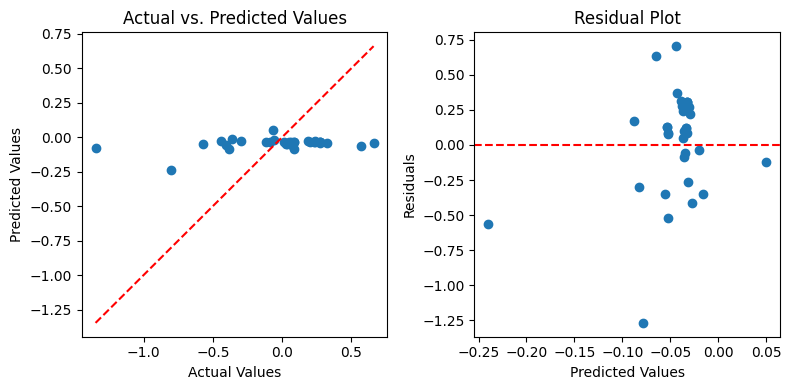

In [6]:
# First model
first_model = perform_linear_regression(X_a, y)


Mean Squared Error (MSE): 1.3844e-01
Mean Absolute Error (MAE): 2.8156e-01
R-squared (R²) Score: 5.2803e-02
Coefficients:
0.03329976850373663
-0.0015590552785321769


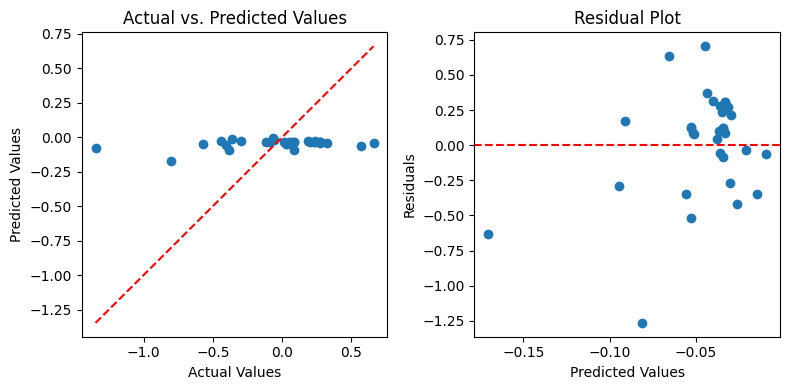

In [8]:
# Second model
second_model = perform_linear_regression(X_b, y)

In [8]:
# Save both models in a pickle file
def save_model(model, model_name):
    model_file_path = os.path.join(saved_models_path, f'relative_model_two_cars/{model_name}.pkl')
    
    with open(model_file_path, 'wb') as file:
        pickle.dump(model, file)
    
    print(f'Model "{model_name}" saved to: {model_file_path}')

save_model(first_model, 'first_model')
save_model(second_model, 'second_model')



Model "first_model" saved to: /home/ali/tum/motion_planning/social_ai_practical_course/results/models/relative_model_two_cars/first_model.pkl
Model "second_model" saved to: /home/ali/tum/motion_planning/social_ai_practical_course/results/models/relative_model_two_cars/second_model.pkl
